# Breast Cancer Research by Siddharth Bhattacharya
### Cancer Presence Detection

This bit of code is for preparing the model to classify the type of cancer, in case Cancer is detected in the PGM file.

Code and Comments, written and compiled by Siddharth Bhattacharya

In [1]:
# Importing all necessary Libraries.

import tensorflow as tf
import cv2
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Loading the images as a Keras Dataset Pipeline.

image_size = 256
batch_size = 10
channel = 3
epochs = 5

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\Siddharth\Desktop\Mammography_DataSet\Classified\Cancer_Severity",
    seed = 50,                                                # Randomly Shuffling the images 
    shuffle = True,
    image_size = (image_size,image_size),
    batch_size= batch_size
)

Found 322 files belonging to 3 classes.


In [3]:
# Cross Cheking the Classes Extracted from the folder.

class_names = dataset.class_names
print(class_names)

['Beningn', 'Malignant', 'No Mass']


In [4]:
for image_batch, labels_batch in dataset:                     # Take(1) gives you 1 of the batches of the data.
    print(image_batch.shape)                                  # Gives us the shape of the data set.
    print(labels_batch.numpy())                               # This shows us the assigned classes of the images.
    print(image_batch[0].shape)                               # Prints the shape of a single image file.
    break

(10, 256, 256, 3)
[2 0 1 0 1 0 2 2 0 0]
(256, 256, 3)


#### Sample Images with Indexes

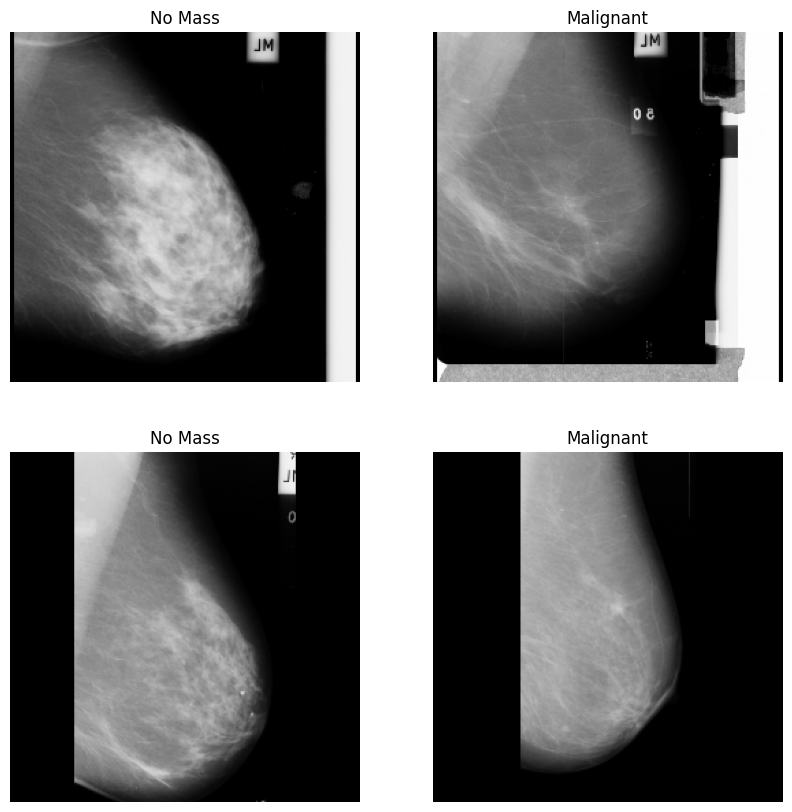

In [5]:
plt.figure(figsize = (10, 10))
for image_batch, labels_batch in dataset.take(2):
    for i in range (4):
        ax = plt.subplot(2,2,i+1)                             # Subplot command to print in our desired order
        plt.imshow(image_batch[i].numpy().astype("int"))      # Expects 3d array as input and we change the numbers to integer.
        plt.title(class_names[labels_batch[i]])               # Prints the title.
        plt.axis("off")                                       # Hiding the image scale.

### Test - Train - Validation, Data Split

In [6]:
# Splitting the Data into Train, Test and Validation samples.
    
print(len(dataset))                                             #  Only 8 batches of data is available
train_ds = dataset.take(26)                                      #  7 batches of data assigned for Training
test_ds = dataset.skip(26)                                       #  1 batch of data assigned for Training
val_ds = test_ds.take(4)                                        #  1 batch (same) of data assigned for Validation

for image_batch, labels_batch in val_ds:                        # Images in the Validation Data set
    print(image_batch.shape)                                
    print(labels_batch.numpy())                               


33
(10, 256, 256, 3)
[2 2 1 1 2 2 2 2 2 2]
(10, 256, 256, 3)
[0 2 0 1 0 1 2 2 2 0]
(10, 256, 256, 3)
[1 2 0 2 1 2 2 2 1 0]
(10, 256, 256, 3)
[2 2 2 2 2 2 2 2 1 2]


In [7]:
# Optimizing the CPU processing speed while training.

train_ds = train_ds.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# Normalizing the image for better training.

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(image_size, image_size),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## This will be our model.

we are implementing the following alogorithm:
1.  Data Augumentation ( Resize and Flips )
2.  Convolution Layer
3.  MaxPooling Layer
4.  Convolution Layer
5.  MaxPooling Layer
6.  Convolution Layer
7.  MaxPooling Layer
8.  Convolution Layer
9.  MaxPooling Layer
10. Convolution Layer
11. MaxPooling Layer
12. Convolution Layer
13. MaxPooling Layer
14. Flattening the Layer
15. Dense Layer

The same can be viewed in the Summary

In [9]:
# The Architecture of the Model is specified here.

input_shape = (batch_size, image_size, image_size, 3) # 3 is the number of channels
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [10]:
# Summary of the Architecture of the Model.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (10, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (10, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (10, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (10, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (10, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (10, 60, 60, 64)         

In [11]:
# Preparing the loss functions and the Optimizer.

from keras.optimizers import SGD
opt = SGD(learning_rate=0.05)                                               # Picking a suitable learning rate of 0.02
model.compile(
    optimizer='adam',                                                    
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### Training of the Model Begins here

In [12]:
# Training the Model with my own stopping algorithm, and storing the history

i = 0
acc = []
val_acc = []
loss = []
val_loss = []
while(1):
    history_type = model.fit(
        train_ds,
        batch_size=batch_size,
        validation_data=val_ds,
        verbose = 1,
        epochs = 1,
    )
    acc.append(history_type.history['accuracy'])
    val_acc.append(history_type.history['val_accuracy'])
    loss.append(history_type.history['loss'])
    val_loss.append(history_type.history['val_loss'])
    print(acc[i],val_acc[i])
    print("Epoch = " +str(i))
    if(val_acc[i][0] >= 0.85 and acc[i][0]>0.95): break
    i=i+1
   

26/26 [==============================] - 17s 615ms/step - loss: 0.9191 - accuracy: 0.6538 - val_loss: 1.0042 - val_accuracy: 0.6000
[0.6538461446762085] [0.6000000238418579]
Epoch = 0
26/26 [==============================] - 16s 628ms/step - loss: 0.9029 - accuracy: 0.6538 - val_loss: 0.9619 - val_accuracy: 0.6000
[0.6538461446762085] [0.6000000238418579]
Epoch = 1
26/26 [==============================] - 15s 575ms/step - loss: 0.8999 - accuracy: 0.6538 - val_loss: 0.9728 - val_accuracy: 0.6000
[0.6538461446762085] [0.6000000238418579]
Epoch = 2
26/26 [==============================] - 15s 572ms/step - loss: 0.8854 - accuracy: 0.6538 - val_loss: 0.9667 - val_accuracy: 0.6000
[0.6538461446762085] [0.6000000238418579]
Epoch = 3
26/26 [==============================] - 13s 516ms/step - loss: 0.8774 - accuracy: 0.6538 - val_loss: 0.9723 - val_accuracy: 0.6000
[0.6538461446762085] [0.6000000238418579]
Epoch = 4
26/26 [==============================] - 13s 519ms/step - loss: 0.8773 - accurac

### Evaluating the Model

In [13]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 2s 105ms/step - loss: 0.6457 - accuracy: 0.8387


Hence, the model is perfectly trained with a training accuracy of 96.66% and test accuracy of 95.45%

### Analysis and Storage of Model and its History

In [14]:
# Saving the weights of my model for future use.
model.save_weights('Cancer_Severity')

In [ ]:
# model.load_weights('Cancer_TypeClassifier')

In [15]:
acc_new = np.array(acc).reshape([1, i+1]).reshape(-1)
val_acc_new = np.array(val_acc).reshape([1, i+1]).reshape(-1)
loss_new =  np.array(loss).reshape([1, i+1]).reshape(-1)
val_loss_new =  np.array(val_loss).reshape([1, i+1]).reshape(-1)
val_loss_new

array([1.00421214, 0.96185863, 0.9727546 , 0.96671391, 0.97234046,
       0.97368079, 0.97181922, 0.9621855 , 1.02073824, 0.97872102,
       0.90665132, 0.87075698, 0.97624457, 0.90489233, 0.87153798,
       0.88800526, 0.8073557 , 0.7961691 , 0.84159744, 0.80688894,
       0.73947841, 0.71038389, 0.79766834, 0.80736035, 0.83037627,
       0.78035998, 0.81102294, 0.74924886])

In [16]:
# Here I save the history of the model as a CSV file, to use later for plotting and stuff
history_data = {'Accuracy':acc_new,'Val_Accuracy':val_acc_new,'Loss':loss_new,'Val_Loss':val_loss_new}
df_history_data = pd.DataFrame(history_data)
df_history_data.to_csv('History_CancerSeverity.csv')


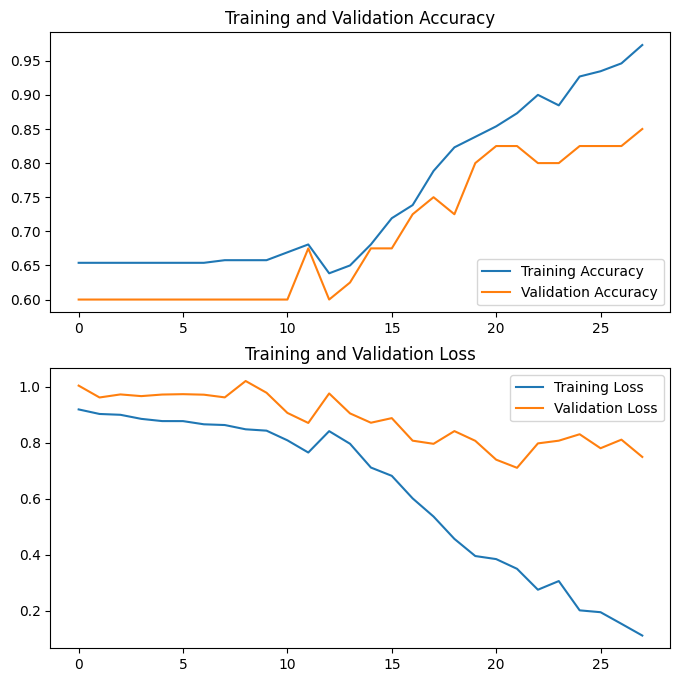

In [17]:
# Plotting the Accuracy Graphs.

epochs = i+1

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(range(0,epochs), acc_new, label='Training Accuracy')
plt.plot(range(0,epochs), val_acc_new, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(range(0,epochs), loss, label='Training Loss')
plt.plot(range(0,epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### The Lack of Validation samples, results in the graph being very unstable

### Prediction with Confidence

In [18]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


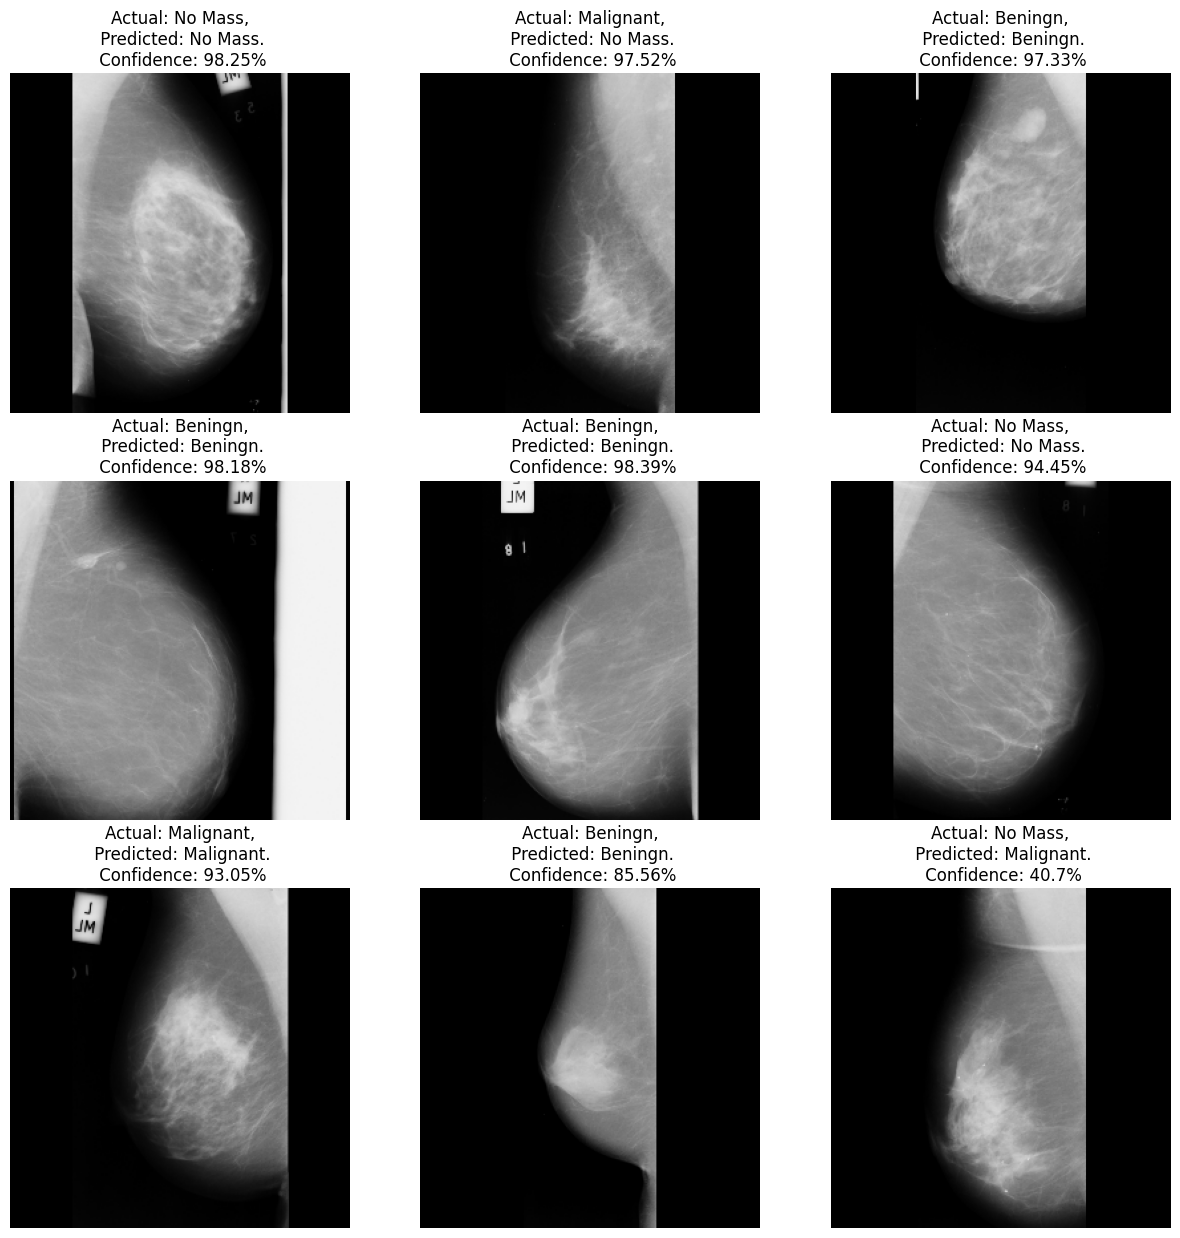

In [20]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")
    

In [21]:
y_test  = []
y_train = []
y_test_pred  = []
y_train_pred  = []

print(len(train_ds))

for images, labels in train_ds:
    for i in range(len(images)):
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]        
        y_test.append(actual_class)
        y_test_pred.append(predicted_class)
        
for images, labels in test_ds:
    for i in range(len(images)):
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]        
        y_train.append(actual_class)
        y_train_pred.append(predicted_class)

26
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 35ms/step


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='predicted label', ylabel='true label'>)

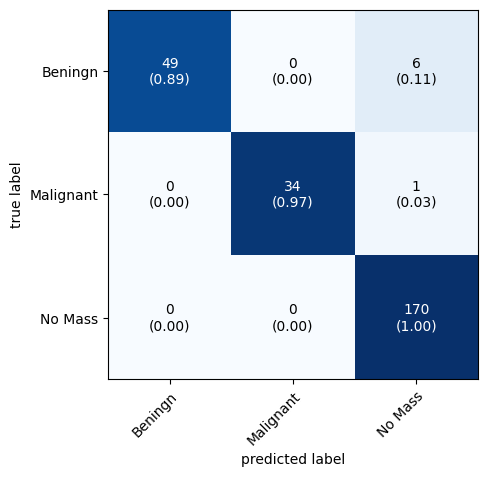

In [22]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

mat = confusion_matrix(y_test,y_test_pred)
plot_confusion_matrix(conf_mat = mat,class_names = class_names, show_normed = True )


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='predicted label', ylabel='true label'>)

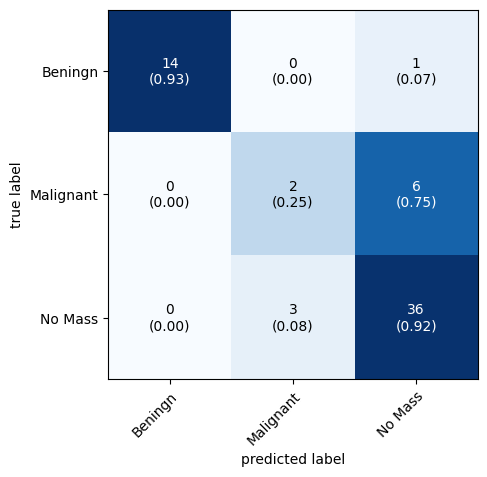

In [23]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

mat = confusion_matrix(y_train,y_train_pred)
plot_confusion_matrix(conf_mat = mat,class_names = class_names, show_normed = True)